In [1]:
import spacy
from spacy import displacy
from allennlp.predictors.predictor import Predictor
import pandas as pd
from transformers import pipeline
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from flair.data import Sentence
from flair.models import SequenceTagger

sns.set() 
ner_tagger = pipeline("ner")
tagger = SequenceTagger.load('ner')
NER = spacy.load("en_core_web_sm")
model_url = "https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2020.02.27.tar.gz"
predictor = Predictor.from_path(model_url)

c:\users\veselin\appdata\local\programs\python\python38\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english)


2022-05-04 22:43:58,313 loading file C:\Users\veselin\.flair\models\ner-english\4f4cdab26f24cb98b732b389e6cebc646c36f54cfd6e0b7d3b90b25656e4262f.8baa8ae8795f4df80b28e7f7b61d788ecbb057d1dc85aacb316f1bd02837a4a4
2022-05-04 22:44:00,618 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


error loading _jsonnet (this is expected on Windows), treating C:\Users\veselin\AppData\Local\Temp\tmpxwcrxg9k\config.json as plain json
Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [215]:
# load data
data = pd.read_csv('Data/elon_mulk_tweets.csv')
data.head()

,date,tweet,language,tweet_length,number_of_tokens,sentence_count
0,2010-06-04 18:31:57,"Please ignore prior tweets, as that was someon...",en,92,17,1
1,2011-12-28 22:27:08,So true :),en,20,4,1
2,2011-12-27 23:38:55,If you ever wanted to know the *real* truth ab...,en,118,18,1
3,2011-12-26 16:29:50,Walked around a neighborhood recently rebuilt ...,en,97,13,1
4,2011-12-26 16:23:04,"It was Xmas, so we brought presents for the ki...",en,117,19,3


## Preprocess data before extracting NER

In [40]:
data = data.dropna()

In [41]:
# replace personal pronouns first form(I, me) with Elon Musk and Tesla
def replace_personal_pronouns(tweet):
    tweet = tweet.replace(' me ', ' Elon Musk ')
    tweet = tweet.replace(' I ', ' Elon Musk ')
    return tweet
data['tweet'] = data.tweet.map(lambda tweet:replace_personal_pronouns(tweet))

In [220]:
# coref resolves personal pronouns between sentences
text = "Veselin is a master's student at DKE. He is currently participating in the IRTM course. His passion is NER."
print(predictor.coref_resolved(text))

Veselin is a master's student at DKE. Veselin is currently participating in the IRTM course. Veselin's passion is NER.


In [53]:
# resolve coreference 
def coref_resolve(tweet):
    if len(tweet) > 50:
        return predictor.coref_resolved(tweet)
    else:
        return tweet
data['tweet'] = data.tweet.map(lambda tweet:coref_resolve(tweet))

In [54]:
# save data
data.to_csv('Data/elon_musk_tweets_ner.csv', index=False)

## Extract NER  (Location, Orgaization, Person)

In [2]:
data = pd.read_csv("Data/elon_musk_tweets_ner.csv")

### Comparison

In [3]:
# Flair NER predictions
sentence = Sentence('You can now buy a Tesla with Bitcoin.')
tagger.predict(sentence)
for entity in sentence.get_spans('ner'):
    print(entity)
    

Span[5:6]: "Tesla" → ORG (0.9929)
Span[7:8]: "Bitcoin" → ORG (0.6285)


In [4]:
# Hugging Face NER predictions
test_text = "You can now buy a Tesla with Bitcoin."
outputs = ner_tagger(test_text)
pd.DataFrame(outputs)

,entity,score,index,word,start,end
0,I-MISC,0.992528,6,Te,18,20
1,I-MISC,0.959386,7,##sla,20,23
2,I-MISC,0.842477,9,Bit,29,32
3,I-ORG,0.487922,10,##co,32,34


In [12]:
# save data
ner_tags = ner_tags_flair

### Extraction

In [ ]:
# use Flair to extract NER

ner_tags_flair = pd.DataFrame(columns = ['WORD', 'NER'])
                
for enum, row in enumerate(data.tweet.values):
    if len(row) > 0:
        sentence = Sentence(row)
        tagger.predict(sentence)
        print(enum)
        for entity in sentence.get_spans('ner'):
            ner_tags_flair = ner_tags_flair.append({'WORD': entity.text, 'NER': entity.get_label("ner").value}, ignore_index=True)
# save data
ner_tags_flair.to_csv('Data/ner_tags_flair.csv', index=False)

In [127]:
# use Hugging Face to extract NER
def ner_tags(tweet):
    outputs = ner_tagger(tweet)
    word = ''
    entity = []
    entities = []
    for x in outputs:
        if x['word'][0:2] == '##':
            word += x['word'][2:]
            entity.append(x['entity'])
        else:
            if word != '':
                entities.append([word, max(set(entity), key=entity.count)])
                entity = []
                word = ''
            entity.append(x['entity'])
            word += x['word']
    if len(entity) > 0:
        entities.append([word, max(set(entity), key=entity.count)])
    return entities
data['ner_tags'] = data.tweet.map(lambda tweet:ner_tags(tweet))

# save data
data.to_csv('Data/elon_musk_tweets_ner.csv', index=False)

In [45]:
temp

,date,tweet,language,tweet_length,number_of_tokens,sentence_count,ner_tags
0,2010-06-04 18:31:57,"Please ignore prior tweets, as that was someon...",en,92,17,1,"[['Elon', 'I-PER'], ['Musk', 'I-PER']]"
1,2011-12-28 22:27:08,So true :),en,20,4,1,[]
2,2011-12-27 23:38:55,If you ever wanted to know the *real* truth ab...,en,118,18,1,"[['Onion', 'I-ORG']]"
3,2011-12-26 16:29:50,Walked around a neighborhood recently rebuilt ...,en,97,13,1,"[['APJ', 'I-ORG']]"
4,2011-12-26 16:23:04,"It was Xmas, so we brought presents for the ki...",en,117,19,3,"[['X', 'I-MISC']]"
...,...,...,...,...,...,...,...
14550,2022-01-03 00:00:00,Reminds Elon Musk of when Elon Musk edited Ult...,en,75,17,1,"[['Elon', 'I-PER'], ['Musk', 'I-PER'], ['Elon'..."
14551,2022-01-03 00:00:00,Yay Switzerland!!,en,142,12,2,"[['Switzerland', 'I-LOC']]"
14552,2022-01-03 00:00:00,There is no way to be in touch with voters whe...,en,100,19,1,[]
14553,2022-01-02 00:00:00,Let’s make the roaring 20’s happen!,en,35,6,1,[]


In [136]:
data.to_csv('Data/ner_tags.csv', index=False)

### Vizualize ner tags per categories

In [10]:
# helper function for wordclouds based on category
def create_wordcloud(category):
    list_verb = ner_tags.loc[ner_tags['NER'] == category]['WORD'].tolist()
    list_verb = [x for x in list_verb if x not in ['\'s', '\'re', '\'m', 'm', 're', 's']]
    unique_string=(" ").join(list_verb)
    wordcloud = WordCloud(width = 700, height = 300, stopwords = []).generate(unique_string)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    plt.close()

In [ ]:
# named entity counts
ner_tags = pd.read_csv("Data/")
df_top_ner = ner_tags.groupby('NER')['NER'].count().\
    reset_index(name='count').sort_values(['count'],ascending=False)

ner_tags['NER'] = pd.Categorical(ner_tags['NER'], df_top_ner['NER'].values)

plt.figure(figsize = (15,5))
sns.histplot(x='NER', data=ner_tags,)
plt.title('Number of value per named entity')

Text(0.5, 1.0, 'Number of value per named entity')

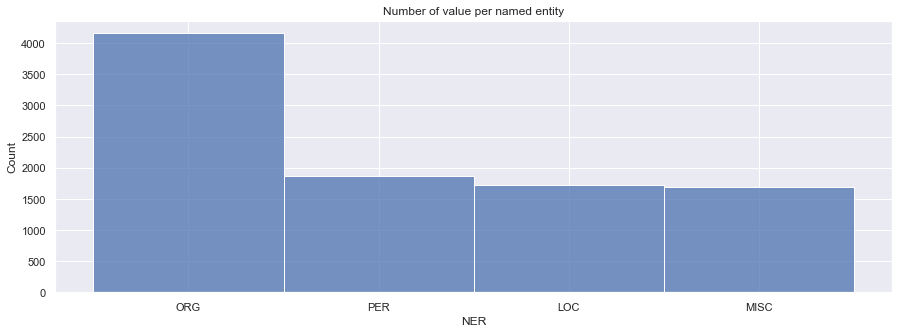

In [13]:
# named entity counts
df_top_ner = ner_tags.groupby('NER')['NER'].count().\
    reset_index(name='count').sort_values(['count'],ascending=False)

ner_tags['NER'] = pd.Categorical(ner_tags['NER'], df_top_ner['NER'].values)

plt.figure(figsize = (15,5))
sns.histplot(x='NER', data=ner_tags,)
plt.title('Number of value per named entity')

### Explore most frequent MISC values

Text(0.5, 1.0, 'Most frequent MISC values')

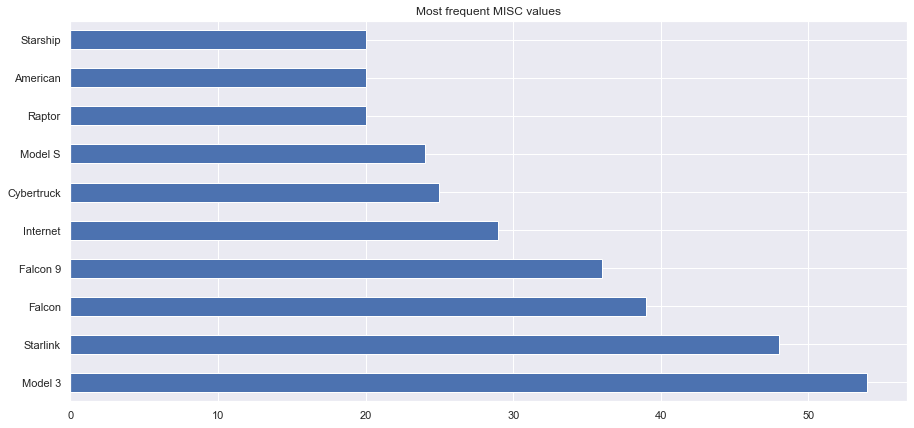

In [40]:
# Most frequent I-MISC values
plt.figure(figsize = (15,7))
ner_tags[ner_tags['NER'] == 'MISC']['WORD'].value_counts().head(10).plot(kind='barh')
plt.title('Most frequent MISC values')

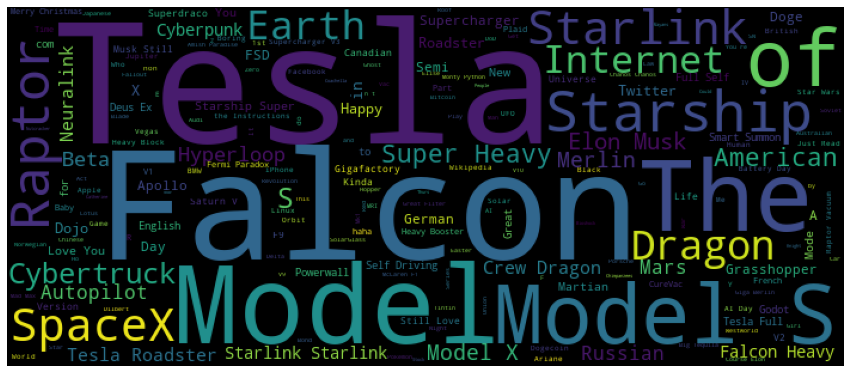

In [32]:
# wordcloud I-MISC
create_wordcloud('MISC')

### Explore most frequent I-ORG values

Text(0.5, 1.0, 'Most frequent ORG values')

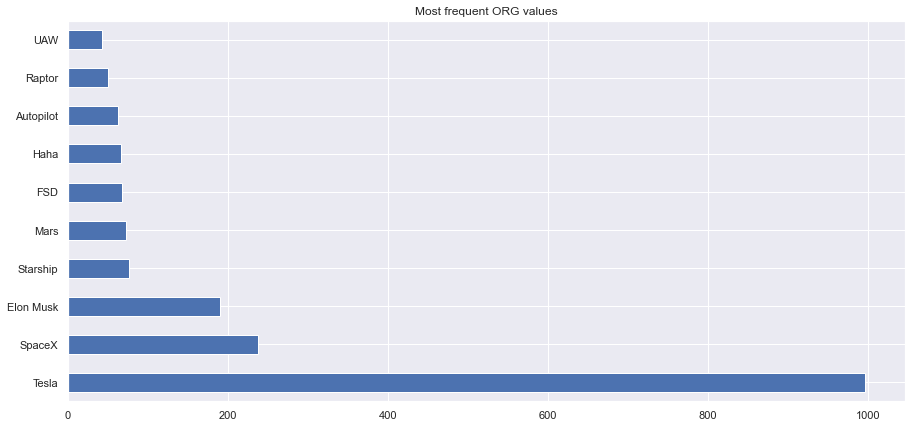

In [39]:
# Most frequent I-ORG values
plt.figure(figsize = (15,7))
ner_tags[ner_tags['NER'] == 'ORG']['WORD'].value_counts().head(10).plot(kind='barh')
plt.title('Most frequent ORG values')

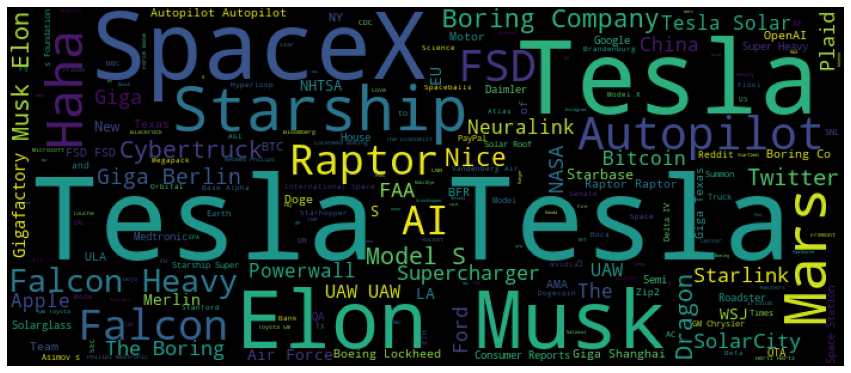

In [18]:
# wordcloud I-ORG
create_wordcloud('ORG')

### Explore most frequent I-PER values

Text(0.5, 1.0, 'Most frequent PER values')

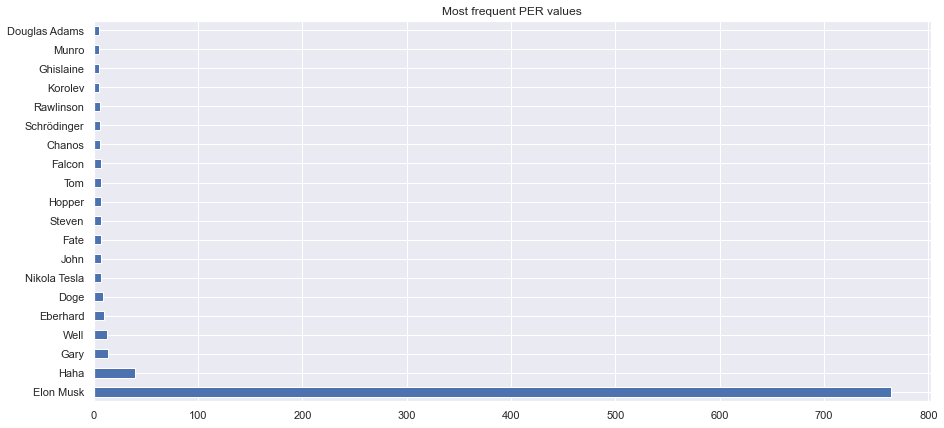

In [41]:
# Most frequent I-PER values
plt.figure(figsize = (15,7))
ner_tags[(ner_tags['NER'] == 'PER') ]['WORD'].value_counts().head(20).plot(kind='barh')
plt.title('Most frequent PER values')

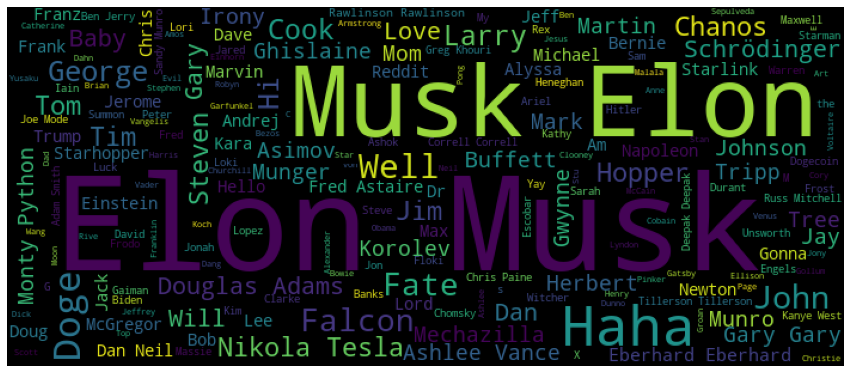

In [20]:
# wordcloud I-PER
create_wordcloud('PER')

### Explore most frequent I-LOC values

Text(0.5, 1.0, 'Most frequent LOC values')

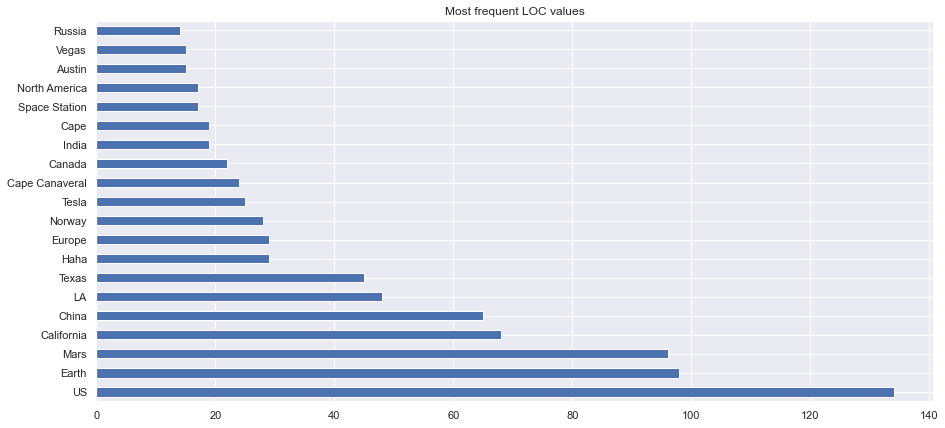

In [42]:
# Most frequent I-LOC values
plt.figure(figsize = (15,7))
ner_tags[ner_tags['NER'] == 'LOC']['WORD'].value_counts().head(20).plot(kind='barh')
plt.title('Most frequent LOC values')

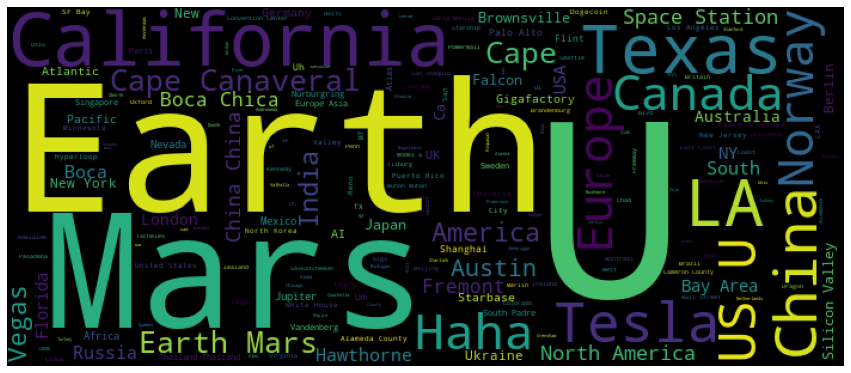

In [28]:
# wordcloud I-PER
create_wordcloud('LOC')

## MISC

In [199]:
from googlesearch  import search
import yfinance as yahooFinance

def name_convert(self):

    searchval = 'yahoo finance '+self
    link = []
    #limits to the first link
    for url in search(searchval, tld='es', lang='es', stop=1):
        link.append(url)

    link = str(link[0])
    link=link.split("/")
    if link[-1]=='':
        ticker=link[-2]
    else:
        x=link[-1].split('=')
        ticker=x[-1]

    return(ticker)

#Function uses yahoo finance to return opening ,closing, and percent change. More get_ methods can be tested, available on the yahoo-finance python documentation.
def company_data(ticker):
    get_company_info = yahooFinance.Ticker(ticker)
 
    # Valid options are 1d, 5d, 1mo, 3mo, 6mo, 1y,
    # 2y, 5y, 10y and ytd.
    return get_company_info


#Comment out when testing

company_name=''
company=name_convert(company_name)
#print(company_data(company))

In [192]:
ner_tags[ner_tags['NER'] == 'I-ORG']['WORD'].value_counts().head(20)
for company in ner_tags[ner_tags['NER'] == 'I-ORG']['WORD'].value_counts().head(20).keys():
    ticker = name_convert(company)
    print(company + ' ==> ' + ticker)
    print(company_data(ticker))

Tesla ==> TSLA
                   Open         High          Low        Close    Volume  \
Date                                                                       
2021-10-25   950.530029  1045.020020   944.200012  1024.859985  62852100   
2021-10-26  1024.689941  1094.939941  1001.440002  1018.429993  62415000   
2021-10-27  1039.660034  1070.880005  1030.780029  1037.859985  38526500   
2021-10-28  1068.310059  1081.000000  1054.199951  1077.040039  27213200   
2021-10-29  1081.859985  1115.209961  1073.209961  1114.000000  29918400   
...                 ...          ...          ...          ...       ...   
2022-04-18   989.030029  1014.919983   973.409973  1004.289978  17238400   
2022-04-19  1005.059998  1034.939941   995.330017  1028.150024  16615900   
2022-04-20  1030.000000  1034.000000   975.250000   977.200012  23570400   
2022-04-21  1074.729980  1092.219971   996.419983  1008.780029  35138800   
2022-04-22  1014.909973  1034.849976   994.000000  1005.049988  23181600 

Elon ==> elon
- ELON: No data found for this date range, symbol may be delisted
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
None
UAW ==> finance.yahoo.com
- FINANCE.YAHOO.COM: No data found, symbol may be delisted
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
None
The ==> finance.yahoo.com
- FINANCE.YAHOO.COM: No data found, symbol may be delisted
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
None
Company ==> finance.yahoo.com
- FINANCE.YAHOO.COM: No data found, symbol may be delisted
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
None
AI ==> AI
                 Open       High        Low      Close   Volume  Dividends  \
Date                                                                         
2021-10-25  46.060001  46.349998  45.564999  45.959999  1142300          0   
2021-10-26  46.250000  48.330002  45.529999  45.560001  2328800          0   
202

In [205]:
company_data('dsfdsf').info

{'regularMarketPrice': None, 'preMarketPrice': None, 'logo_url': ''}

In [209]:
import spacy
from spacy import displacy

# Load the language model
nlp = spacy.load("en_core_web_sm")

In [213]:
sentence = data.tweet.values[2]

# nlp function returns an object with individual token information, 
# linguistic features and relationships
doc = nlp(sentence)

print ("{:<15} | {:<8} | {:<15} | {:<20}".format('Token','Relation','Head', 'Children'))
print ("-" * 70)

for token in doc:
  # Print the token, dependency nature, head and all dependents of the token
  print ("{:<15} | {:<8} | {:<15} | {:<20}"
         .format(str(token.text), str(token.dep_), str(token.head.text), str([child for child in token.children])))
  
 # Use displayCy to visualize the dependency 
displacy.render(doc, style='dep', jupyter=True, options={'distance': 120})

Token           | Relation | Head            | Children            
----------------------------------------------------------------------
If              | mark     | wanted          | []                  
you             | nsubj    | wanted          | []                  
ever            | advmod   | wanted          | []                  
wanted          | advcl    | article         | [If, you, ever, know, ...]
to              | aux      | know            | []                  
know            | xcomp    | wanted          | [to, truth]         
the             | det      | truth           | []                  
*               | punct    | truth           | []                  
real            | amod     | truth           | []                  
*               | punct    | truth           | []                  
truth           | dobj     | know            | [the, *, real, *, about]
about           | prep     | truth           | [landings]          
the             | det      | landin

In [ ]:
Jaccard coefficient for similarity between entities. If > 80 then they are the same entity
Q-distance aka Q-grams aka Dice’s Coefficient aka Letter pair similarity (updated version of Jaccard coefficient)
soundex can work good
edit distance
monge elkan - max similarity of each token using another function example(Levenshtein)
jaro winkler distance (combination of levenshtein and jaccard coeficcient)